In [1]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np

data = pd.read_csv("20120901_20190916-PM10_auto.csv",sep=';') # test PM10 first 

dataLegend = data.loc[0] # remove legend (unit) from first row
data = data.loc[1:]

hourArr = []
dateArr = []

data.head()

for i in data.heure:
    hr = int(i) - 1 # to turn 24 into 0
    if hr==-1:      # to turn 24 into 0
        hr = 23     # to turn 24 into 0
    hourString = str(hr)
    hourString = hourString.zfill(2) + ":59:00"  # to turn 24 into 0
    hourArr.append(hourString)
for i in data.date:
    date = i[6:10] + "-" + i[3:5] + "-" + i[0:2] + " "
    dateArr.append(date)    

#tempData = data.ELYS
#tempData = data.ELYS.tolist()
#print(type(tempData))
#tempData.replace('n/d',np.nan)
#print(tempData)
fname = 'ELYS'
d = {'date': dateArr,'hour': hourArr, 'y': data.ELYS} # choose data from Opera (close to Auber)

df = pd.DataFrame(data=d)
df['ds'] = df['date'] + df['hour']
del df['date']
del df['hour']
columnsTitles=['ds','y']
df=df.reindex(columns=columnsTitles)
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'] + pd.Timedelta('1 min') # to turn 24 into 0
df['y'] = df['y'].replace('n/d', np.nan) # turn d/s into NaN


df.to_pickle("airQualityDataframe-" + fname + ".pkl")

df = df[0:1000]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


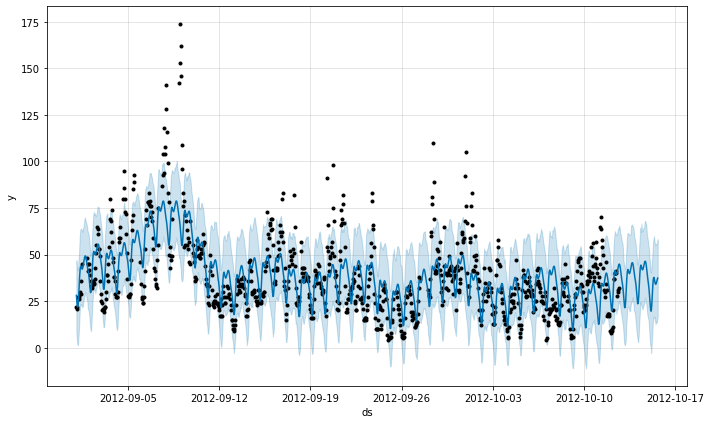

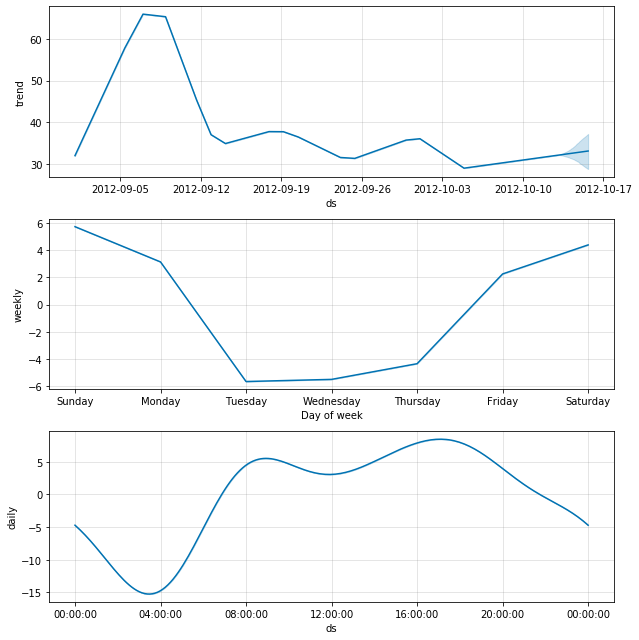

In [9]:
from fbprophet import Prophet
m = Prophet(changepoint_prior_scale=0.1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=72, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [10]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='20 days', period='2 days', horizon = '3 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2012-09-21 16:00:00 and 2012-10-09 16:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-09-21 17:00:00,69.862543,50.904034,90.000104,24,2012-09-21 16:00:00
1,2012-09-21 18:00:00,72.058341,52.048012,91.283337,19,2012-09-21 16:00:00
2,2012-09-21 19:00:00,72.059269,50.671793,92.521350,19,2012-09-21 16:00:00
3,2012-09-21 20:00:00,69.892647,50.975430,89.692142,21,2012-09-21 16:00:00
4,2012-09-21 21:00:00,67.032987,47.767288,86.935337,26,2012-09-21 16:00:00


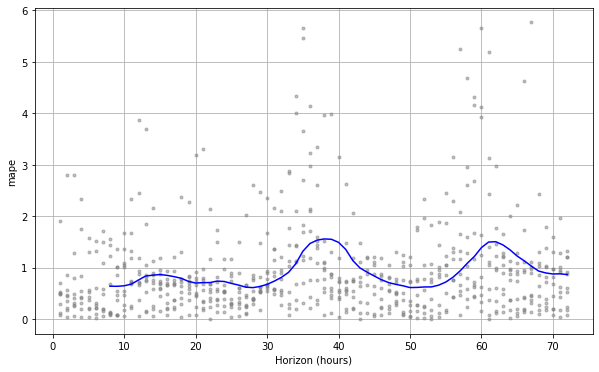

In [11]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
